# Stable Diffusion XL을 이용한 이미지 생성

> 이 노트북은 SageMaker Studio의 **`Data Science 3.0`** 커널과 SageMaker 노트북 인스턴스의 **`conda_python3`** 에서 잘 작동해야 합니다.

---

이 노트북에서는 이미지 생성(text-to-image)과 이미지 편집(image-to-image)을 위해 [Amazon Bedrock](https://aws.amazon.com/bedrock/)에서 [Stable Diffusion XL](https://stability.ai/stablediffusion)(SDXL)을 사용하는 방법을 보여드리겠습니다.

Stable Diffusion의 이미지는 아래의 4가지 주요 모델에 의해 생성됩니다.
1. The CLIP text encoder;
2. The VAE decoder;
3. The UNet, and
4. The VAE_post_quant_conv

이러한 블록은 파이프라인에서 컴퓨팅의 대부분을 차지하기 때문에 선택됩니다.

아래 다이어그램을 참조하세요.

![SD Architecture](./images/sd.png)

### 이미지 프롬프팅

좋은 프롬프트를 작성하는 것은 일종의 예술일 수 있습니다. 특정 프롬프트가 주어진 모델에서 만족스러운 이미지를 생성할지 예측하기 어려운 경우가 많습니다. 하지만 효과가 있는 것으로 관찰된 특정 템플릿이 있습니다. 프롬프트는 크게 세 가지로 나눌 수 있습니다:

1. 이미지의 **Type** (photograph/sketch/painting 등)
2. 콘텐츠의 **Description** (주제/사물/환경/장면 등), 그리고
3. 이미지의 **Style** (사실적/예술적/예술 유형 등).

세 부분을 각각 개별적으로 변경하여 이미지의 변형을 생성할 수 있습니다. 형용사는 이미지 생성 과정에서 중요한 역할을 하는 것으로 알려져 있습니다. 또한 세부 정보를 추가하면 생성 과정에 도움이 됩니다.

사실적인 이미지를 생성하려면 "a photo of", "a photograph of", "realistic" 또는 "hyper realistic"과 같은 문구를 사용할 수 있습니다. 아티스트별 이미지를 생성하려면 “by Pablo Piccaso”, “oil painting by Rembrandt”, “landscape art by Frederic Edwin Church”, “pencil drawing by Albrecht Dürer” 등의 문구를 사용할 수 있습니다. 여러 아티스트를 결합할 수도 있습니다. 카테고리별로 예술적 이미지를 생성하려면 “lion on a beach, abstract”과 같이 프롬프트에 예술 카테고리를 추가하면 됩니다. 다른 카테고리로는 “oil painting”, “pencil drawing", “pop art”, “digital art”, “anime”, “cartoon”, “futurism”, “watercolor”, “manga” 등이 있습니다. 조명이나 카메라 렌즈(예: 35mm wide lens or 85mm wide lens), 구도(portrait/landscape/close up 등)에 대한 세부 정보도 포함할 수 있습니다.

동일한 프롬프트가 여러 번 주어지더라도 모델은 다른 이미지를 생성합니다. 따라서 여러 이미지를 생성하여 애플리케이션에 가장 적합한 이미지를 선택할 수 있습니다.

## Setup

⚠️ ⚠️ ⚠️ 실습을 실행하기 전에 [Bedrock boto3 setup 노트북](setup/bedrock_boto3_setup.ipynb)을 실행했는지 확인합니다. ⚠️ ⚠️ ⚠️


In [2]:
# Python Built-Ins:
import base64
import io
import json
import os
import sys

# External Dependencies:
import boto3
from PIL import Image

module_path = "."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww


# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

# os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
# os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
# os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."

boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


## Text to Image

Text to Image 변환 모드에서는 `prompt` 라고 하는 어떤 이미지가 생성되어야 하는지에 대한 텍스트 설명을 제공합니다.

SDXL(Stable Diffusion XL)을 사용하면 특정 [style presets](https://platform.stability.ai/docs/release-notes#style-presets)을 지정하여 생성에 영향을 줄 수도 있습니다.

이미지 생성에 더 많은 영향을 미치기 위해 [clip guidance presets](https://platform.stability.ai/docs/features/api-parameters#clip_guidance) 및 [samplers](https://platform.stability.ai/docs/features/api-parameters#sampler)를 사용하여 보다 바람직한 결과를 얻을 수 있습니다. 

현재 SDXL 모델은 기본적으로 정사각형 [해상도](https://platform.stability.ai/docs/features/api-parameters#about-dimensions)인 512픽셀 x 512픽셀로 설정되어 있지만, 이보다 높은 해상도와 비정사각형 종횡비로 이미지를 생성할 수 있습니다. 아래 그림과 같이 이미지의 `width`는 768px로 설정하고 `height`는 기본값인 512px로 유지했습니다. 

하지만 특정 콘텐츠나 스타일 선택을 ***회피***하도록 모델을 넛지하고 싶다면 어떻게 해야 할까요? 이미지 생성 모델은 일반적으로 *image descriptions*을 통해 학습되기 때문에 프롬프트에서 원하지 않는 것을 직접 지정하려고 시도하는 것은 일반적으로 잘 작동하지 않습니다(예: 'man without a beard'): 이미지가 아닌 것으로 이미지를 설명하는 것은 매우 드문 일이기 때문입니다!

대신 SDXL을 사용하면 각 프롬프트에 대해 `weight`를 지정할 수 있으며, 이는 음수일 수 있습니다. 이를 사용하여 아래와 같이 `negative_prompts`를 제공하겠습니다:

In [3]:
prompt = "a beautiful mountain landscape"
negative_prompts = [
    "poorly rendered",
    "poor background details",
    "poorly drawn mountains",
    "disfigured mountain features",
]
style_preset = "photographic"  # (e.g. photographic, digital-art, cinematic, ...)
clip_guidance_preset = "FAST_GREEN" # (e.g. FAST_BLUE FAST_GREEN NONE SIMPLE SLOW SLOWER SLOWEST)
sampler = "K_DPMPP_2S_ANCESTRAL" # (e.g. DDIM, DDPM, K_DPMPP_SDE, K_DPMPP_2M, K_DPMPP_2S_ANCESTRAL, K_DPM_2, K_DPM_2_ANCESTRAL, K_EULER, K_EULER_ANCESTRAL, K_HEUN, K_LMS)
width = 768

Amazon Bedrock `InvokeModel`은 올바른 모델 ID를 설정하여 SDXL에 대한 액세스를 제공하며, (PNG) 이미지를 나타내는 [Base64 encoded string](https://en.wikipedia.org/wiki/Base64)이 포함된 JSON 응답을 반환합니다.

모델에 사용할 수 있는 입력 파라미터에 대한 자세한 내용은 [Stability AI docs](https://platform.stability.ai/docs/api-reference#tag/v1generation/operation/textToImage)를 참조하세요.

아래 셀은 Amazon Bedrock을 통해 SDXL 모델을 호출하여 initial image string을 생성합니다:

In [4]:
request = json.dumps({
    "text_prompts": (
        [{"text": prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 5,
    "seed": 452345,
    "steps": 60,
    "style_preset": style_preset,
    "clip_guidance_preset": clip_guidance_preset,
    "sampler": sampler,
    "width": width,
})
modelId = "stability.stable-diffusion-xl"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
base_64_img_str = response_body["artifacts"][0].get("base64")
print(f"{base_64_img_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAIACAIAAAC6lJxtAAAEImVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


Base64 문자열을 바이너리로 디코딩하고 PNG 파일을 읽을 수 있는 [Pillow](https://pillow.readthedocs.io/en/stable/)와 같은 이미지 처리 라이브러리로 로드하면 노트북에서 이미지를 표시하고 조작할 수 있습니다:

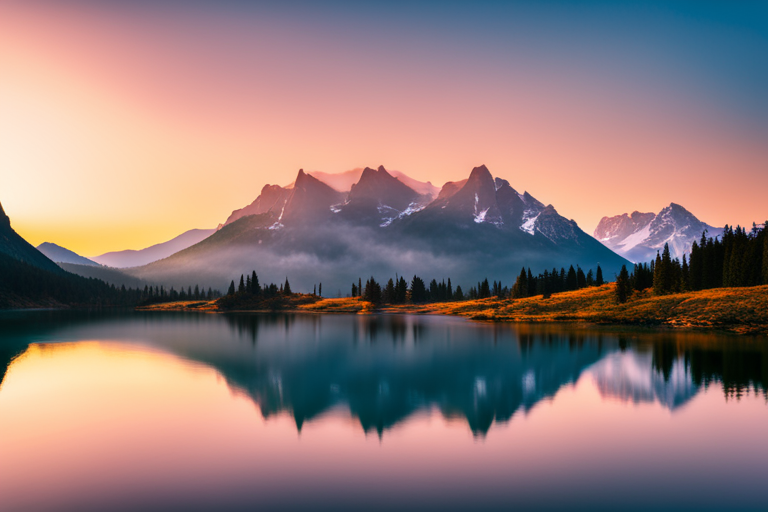

In [5]:
os.makedirs("outputs", exist_ok=True)

image_1 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image_1.save("outputs/image_1.png")
image_1

## Image to Image

텍스트에서 이미지를 생성하는 것은 강력하지만, 경우에 따라 이미지를 "딱 맞게" 만들기 위해 여러 차례의 즉각적인 수정 작업이 필요할 수 있습니다.

매번 텍스트로 처음부터 시작하는 대신 image-to-image 생성을 사용하면 **기존 이미지를 수정**하여 원하는 특정 변경 사항을 적용할 수 있습니다.

초기 이미지를 base64 인코딩으로 API에 전달해야 하므로 먼저 이미지를 준비해 보겠습니다. 이전 섹션의 초기 이미지를 사용하거나 원하는 경우 다른 이미지를 사용할 수 있습니다:

In [6]:
def image_to_base64(img) -> str:
    """Convert a PIL Image or local image file path to a base64 string for Amazon Bedrock"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        print("Converting PIL Image to base64 string")
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")


init_image_b64 = image_to_base64(image_1)
print(init_image_b64[:80] + "...")

Converting PIL Image to base64 string
iVBORw0KGgoAAAANSUhEUgAAAwAAAAIACAIAAAC6lJxtAAEAAElEQVR4nHy9y44tzc4cFszVenRP/CQ2...


이어서 새로운 가이드 프롬프트가 모델이 초기 이미지에서 작동하도록 도울 수 있습니다.

In [7]:
change_prompt = "add denser number of trees, extend lake"

그런 다음 기존 이미지가 `init_image` 매개 변수를 통해 안정적 확산 모델로 전달됩니다.

다양한 파라미터를 사용하는 방법에 대한 자세한 팁은 [Stable Diffusion API Docs](https://platform.stability.ai/docs/api-reference#tag/v1generation/operation/imageToImage)를 참조하세요:

In [8]:
request = json.dumps({
    "text_prompts": (
        [{"text": change_prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 10,
    "init_image": init_image_b64,
    "seed": 321,
    "start_schedule": 0.6,
    "steps": 50,
    "style_preset": style_preset,
    "clip_guidance_preset": clip_guidance_preset,
    "sampler": sampler,
})
modelId = "stability.stable-diffusion-xl"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
image_2_b64_str = response_body["artifacts"][0].get("base64")
print(f"{image_2_b64_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAIACAIAAAC6lJxtAAD0xGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


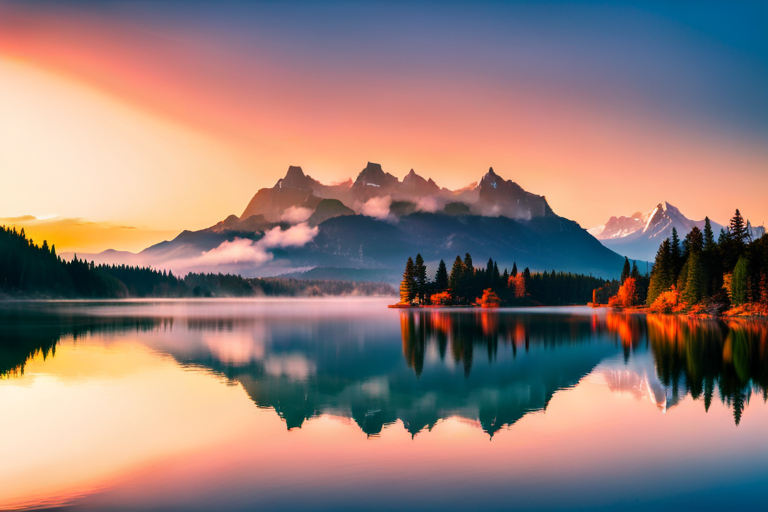

In [9]:
os.makedirs("outputs", exist_ok=True)

image_2 = Image.open(io.BytesIO(base64.decodebytes(bytes(image_2_b64_str, "utf-8"))))
image_2.save("outputs/image_2.png")
image_2

### Image Inpainting

이미지를 수정하는 또 다른 대안은 "Inpainting"을 사용하는 것입니다. 인페인팅은 텍스트 프롬프트에 따라 이미지의 일부를 다른 이미지로 대체하는 프로세스를 말합니다. 대체할 부분의 윤곽을 나타내는 마스크 이미지, 텍스트 프롬프트, 이미지를 제공하면 안정적 확산 모델은 텍스트 프롬프트에 설명된 사물, 피사체 또는 환경으로 마스크 영역을 대체하는 새 이미지를 생성할 수 있습니다.

예제에서는 `data/mask.png` 파일에 제공된 마스크를 사용할 수 있습니다.

**참고**: 마스크 이미지는 칠할 이미지와 해상도 및 종횡비가 동일해야 합니다. 

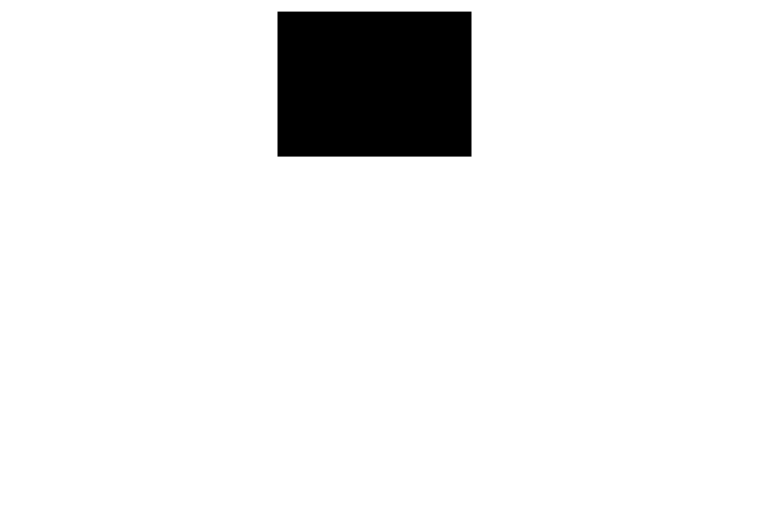

In [10]:
os.makedirs("data", exist_ok=True)

mask = Image.open('data/mask.png').convert("RGB")
mask

이제 이미지에서 변경할 내용을 정의합니다.

In [11]:
inpaint_prompt = "add cloud"

이전에 했던 것과 유사하게 `init_image` 파라미터를 통해 이전에 생성한 이미지를 Stable Diffusion 모델에 전달합니다.

이번에는 마스크를 전달하기 위해 `mask_source` 매개변수도 지정합니다. 

다양한 파라미터를 사용하는 방법에 대한 자세한 팁은 [Stable Diffusion API Dosc](https://platform.stability.ai/docs/api-reference#tag/v1generation/operation/imageToImage)를 참조하세요:

In [12]:
request = json.dumps({
    "text_prompts":[{"text": inpaint_prompt}],
    "init_image": image_to_base64(image_2),
    "mask_source": "MASK_IMAGE_BLACK",
    "mask_image": image_to_base64(mask),
    "cfg_scale": 10,
    "seed": 321,
    "style_preset": style_preset,
})
modelId = "stability.stable-diffusion-xl"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
image_3_b64_str = response_body["artifacts"][0].get("base64")
print(f"{image_2_b64_str[0:80]}...")

Converting PIL Image to base64 string
Converting PIL Image to base64 string
success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAIACAIAAAC6lJxtAAD0xGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


방금 수정한 이미지를 보여드리겠습니다:

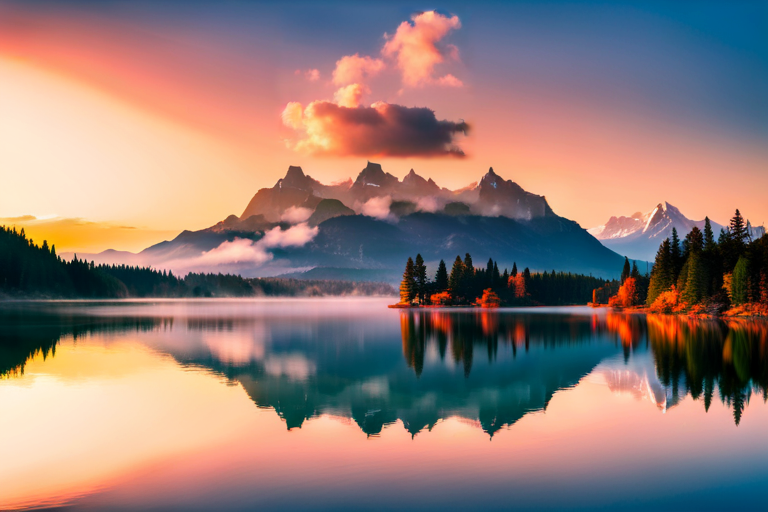

In [13]:
os.makedirs("outputs", exist_ok=True)

inpaint = Image.open(io.BytesIO(base64.decodebytes(bytes(image_3_b64_str, "utf-8"))))
inpaint.save("outputs/inpaint.png")
inpaint

---
## Use Cases

앞서 살펴본 `text-to-image`, `image-to-image` 및 `image inpainting` 방식을 사용한 몇 가지 사용 사례를 살펴보겠습니다.

### Text to Image

컨셉 상품 디자인을 위한 이미지 프롬프팅 예시 입니다.

In [14]:
prompt = "The Bag is a small sports weekender bag suitable for exercise or outdoor activities, and uses a luxurious and solid fabric with a subtle gloss to create a casual yet luxurious mood. It is easy to store small belongings and various pockets are provided."

negative_prompts = [
    "poorly rendered",
    "poor background details",
    "poorly drawn bag",
    "poorly drawn background",
]

style_preset = "enhance"  # (e.g. photographic, digital-art, cinematic, ...)
sampler = "DDIM" # (e.g. DDIM, DDPM, K_DPMPP_SDE, K_DPMPP_2M, K_DPMPP_2S_ANCESTRAL, K_DPM_2, K_DPM_2_ANCESTRAL, K_EULER, K_EULER_ANCESTRAL, K_HEUN, K_LMS)
width = 768


In [15]:
request = json.dumps({
    "text_prompts": (
        [{"text": prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 30,
    "seed": 132,
    "steps": 30,
    "image_strength": 1.0,
    "style_preset": style_preset,
    "sampler": sampler,
    "width": width,
})
modelId = "stability.stable-diffusion-xl"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
base_64_img_str = response_body["artifacts"][0].get("base64")
print(f"{base_64_img_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAIACAIAAAC6lJxtAAAGEmVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


생성된 이미지를 확인해 봅니다.

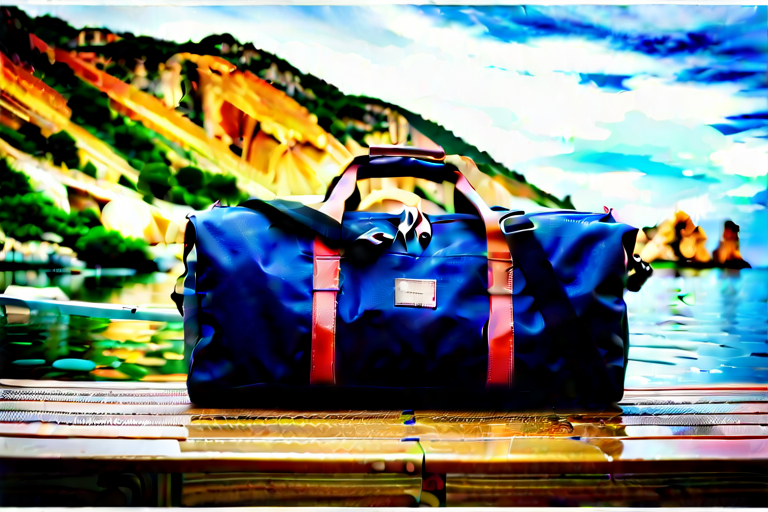

In [16]:
os.makedirs("outputs", exist_ok=True)

product_0 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
product_0.save("outputs/product_0.png")
product_0

### Image to Image

텍스트로 처음부터 시작하는 대신 image-to-image 생성을 사용하면 기존 이미지를 수정하여 원하는 특정 변경 사항을 적용할 수 있습니다.<br>

예시로서 스웨터 이미지를 사용할 것 입니다.

In [17]:
os.makedirs("data", exist_ok=True)

apparel = Image.open('data/apparel.jpg').convert("RGB")

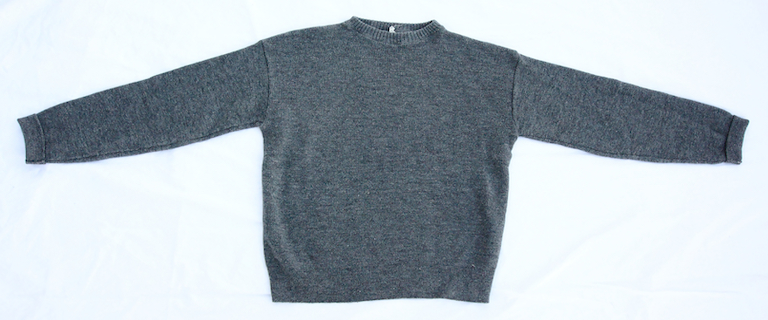

In [18]:
from PIL import Image

def resize_image(image, width, height):
    return image.resize((width, height), Image.BICUBIC)

# image의 width와 height를 64의 배수로 조정
apparel = resize_image(apparel, 768, 320)
apparel

초기 이미지를 base64 인코딩으로 API에 전달해야 하므로 먼저 이미지를 준비해 보겠습니다.

In [19]:
def image_to_base64(img) -> str:
    """Convert a PIL Image or local image file path to a base64 string for Amazon Bedrock"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        print("Converting PIL Image to base64 string")
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")


init_image_b64 = image_to_base64(apparel)
print(init_image_b64[:80] + "...")

Converting PIL Image to base64 string
iVBORw0KGgoAAAANSUhEUgAAAwAAAAFACAIAAACEJIycAAEAAElEQVR4nKz9Wa9lWZImhn1ma5/53Nln...


이어서 새로운 가이드 프롬프트를 통해 모델이 초기 이미지에 대해 작동하도록 합니다.

In [20]:
# Prompt
change_prompt = "a cute cat face picture in a sweater"

negative_prompts = [
    "poorly rendered",
    "poor sweater detail",
]

# parameters
style_preset = "enhance"  # (e.g. photographic, digital-art, cinematic, ...)
clip_guidance_preset = "SLOWEST" # (e.g. FAST_BLUE FAST_GREEN NONE SIMPLE SLOW SLOWER SLOWEST)
sampler = "DDIM" # (e.g. DDIM, DDPM, K_DPMPP_SDE, K_DPMPP_2M, K_DPMPP_2S_ANCESTRAL, K_DPM_2, K_DPM_2_ANCESTRAL, K_EULER, K_EULER_ANCESTRAL, K_HEUN, K_LMS)

In [21]:
request = json.dumps({
    "text_prompts": (
        [{"text": change_prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 9,
    "init_image": init_image_b64,
    "image_strength": 0.8,   # 0.8
    "seed": 30,
    "steps": 150,     # maximum 150
    "style_preset": style_preset,
    "clip_guidance_preset": clip_guidance_preset,
    "sampler": sampler,
})
modelId = "stability.stable-diffusion-xl"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
apparel_b64_str = response_body["artifacts"][0].get("base64")
print(f"{apparel_b64_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAFACAIAAACEJIycAADzbmVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


프롬프트가 반영된 이미지를 저장하고 출력해봅니다.

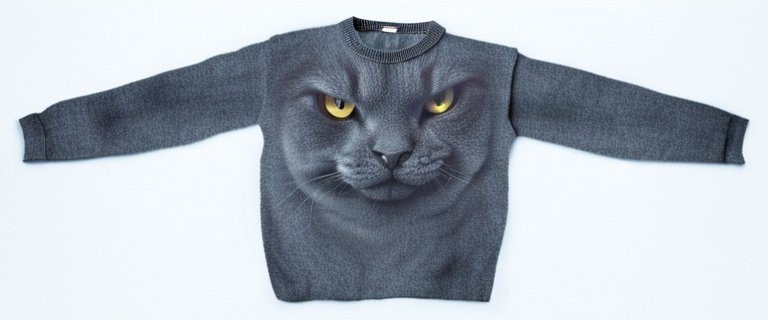

In [22]:
os.makedirs("outputs", exist_ok=True)

apparel_2 = Image.open(io.BytesIO(base64.decodebytes(bytes(apparel_b64_str, "utf-8"))))
apparel_2.save("outputs/apparel_2.png")
apparel_2

### Image Inpainting

#### (1) 새 제품/모델 이미지로 변경

image inpainting에 사용된 원본 이미지 입니다.

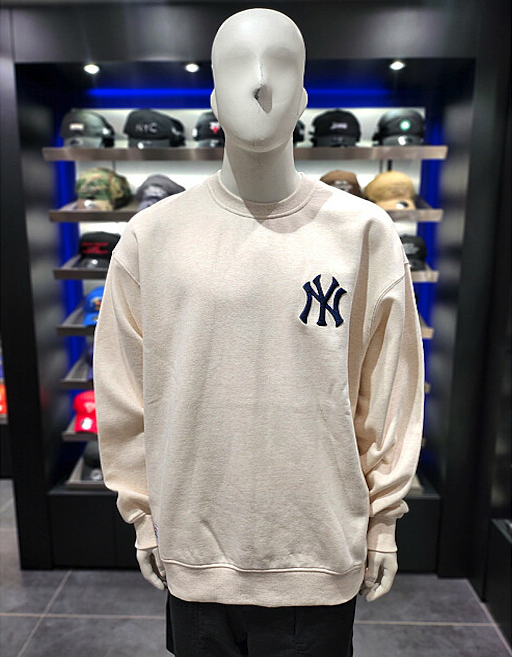

In [23]:
os.makedirs("data", exist_ok=True)

product1 = Image.open('data/1_product.png').convert("RGB")
product1

위 이미지와 동일한 해상도, 종횡비를 가지는 `data/1_product_mask.png` 파일에 제공된 마스크를 사용할 수 있습니다.

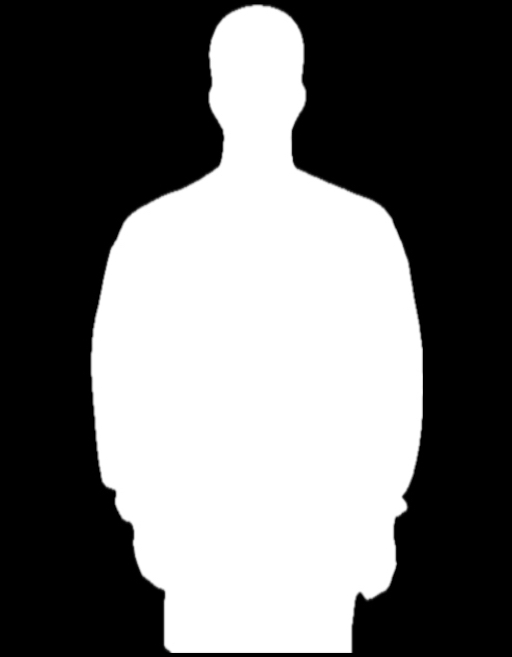

In [24]:
os.makedirs("data", exist_ok=True)
product1_mask = Image.open('data/1_product_mask.png').convert("RGB")
product1_mask

이제 이미지에서 변경할 내용을 정의합니다.

In [25]:
inpaint_prompt = "masterpiece,casual,blouse"

negative_prompts = [
    "poorly rendered",
    "poor background details",
    "poorly drawn hands",
]
style_preset = "photographic"  # (e.g. photographic, digital-art, cinematic, ...)
sampler = "K_DPMPP_2M" # (e.g. DDIM, DDPM, K_DPMPP_SDE, K_DPMPP_2M, K_DPMPP_2S_ANCESTRAL, K_DPM_2, K_DPM_2_ANCESTRAL, K_EULER, K_EULER_ANCESTRAL, K_HEUN, K_LMS)

In [26]:
from PIL import Image

def resize_image(image, width, height):
    return image.resize((width, height), Image.BICUBIC)

# image의 width와 height를 64의 배수로 조정
product1 = resize_image(product1, 512, 640)
product1_mask = resize_image(product1_mask, 512, 640)


request = json.dumps({
    "text_prompts":[{"text": inpaint_prompt}],
    "init_image": image_to_base64(product1),
    "mask_source": "MASK_IMAGE_WHITE",
    "mask_image": image_to_base64(product1_mask),
    "cfg_scale": 8.0,
    "steps": 35, # Amount of inference steps performed on image generation. Defaults to 30.
    "seed": 60,
    "style_preset": style_preset,
    "negative_prompt": negative_prompts,
    "sampler": sampler
})
modelId = "stability.stable-diffusion-xl"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
image_3_b64_str = response_body["artifacts"][0].get("base64")
print(f"{image_3_b64_str[0:80]}...")

Converting PIL Image to base64 string
Converting PIL Image to base64 string
success
iVBORw0KGgoAAAANSUhEUgAAAgAAAAKACAIAAABlqld1AAEZVmVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


수정된 이미지를 출력해봅니다.

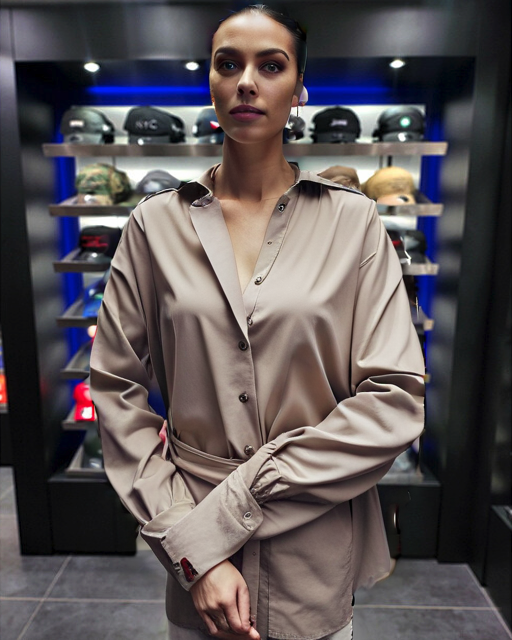

In [27]:
os.makedirs("outputs", exist_ok=True)

inpaint = Image.open(io.BytesIO(base64.decodebytes(bytes(image_3_b64_str, "utf-8"))))
inpaint.save("outputs/product1_result1.png")
inpaint

#### (2) 배경 이미지로 변경

이번에는 원본 이미지에서 배경을 바꿔보겠습니다.

In [28]:
inpaint_prompt = "in London"

negative_prompts = [
    "poorly drawn hands",
    "poor boundaries",
]

style_preset = "photographic"  # (e.g. photographic, digital-art, cinematic, ...)
clip_guidance_preset = "FAST_GREEN" # (e.g. FAST_BLUE FAST_GREEN NONE SIMPLE SLOW SLOWER SLOWEST)
sampler = "K_DPMPP_2S_ANCESTRAL" # (e.g. DDIM, DDPM, K_DPMPP_SDE, K_DPMPP_2M, K_DPMPP_2S_ANCESTRAL, K_DPM_2, K_DPM_2_ANCESTRAL, K_EULER, K_EULER_ANCESTRAL, K_HEUN, K_LMS)

In [29]:
request = json.dumps({
    "text_prompts":[{"text": inpaint_prompt}],
    "init_image": image_to_base64(product1),
    "mask_source": "MASK_IMAGE_BLACK",
    "mask_image": image_to_base64(product1_mask),
    "cfg_scale": 7.5,
    "seed": 12345,
    "style_preset": style_preset,
    "negative_prompt": negative_prompts
})
modelId = "stability.stable-diffusion-xl"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
image_3_b64_str = response_body["artifacts"][0].get("base64")
print(f"{image_3_b64_str[0:80]}...")

Converting PIL Image to base64 string
Converting PIL Image to base64 string
success
iVBORw0KGgoAAAANSUhEUgAAAgAAAAKACAIAAABlqld1AAFSnmVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


수정된 이미지를 출력해봅니다.

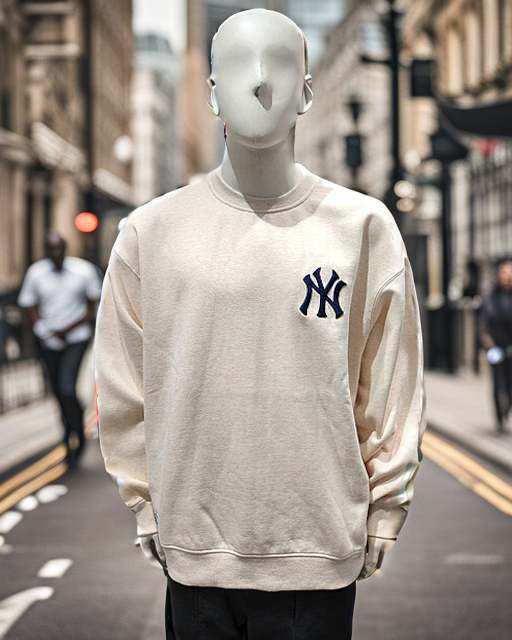

In [30]:
os.makedirs("outputs", exist_ok=True)

inpaint = Image.open(io.BytesIO(base64.decodebytes(bytes(image_3_b64_str, "utf-8"))))
inpaint.save("outputs/product1_result2.png")
inpaint

## 요약

이 실습에서는 [Amazon Bedrock](https://aws.amazon.com/bedrock/)의 [Stable Diffusion XL](https://stability.ai/stablediffusion)을 사용하여 텍스트로부터 새로운 이미지를 생성하고 텍스트 지침으로 기존 이미지를 변환하는 방법을 시연했습니다.

Bedrock API를 통해 이미지 생성에 영향을 주는 다양한 파라미터를 제공할 수 있으며, 이는 일반적으로 [Stable Diffusion API docs](https://platform.stability.ai/docs/api-reference#tag/v1generation)의 내용과 일치합니다.

Bedrock을 사용할 때 주의해야 할 점은 출력 이미지 PNG/JPEG 데이터가 JSON API 응답 내에서 [Base64 encoded string](https://en.wikipedia.org/wiki/Base64)로 반환된다는 점입니다: 파이썬에 내장된 [base64 library](https://docs.python.org/3/library/base64.html)를 사용하여 이 이미지 데이터를 디코딩할 수 있습니다(예: `.png` 파일 저장). 또한 [Pillow](https://pillow.readthedocs.io/en/stable/)와 같은 이미지 처리 라이브러리를 사용하여 Python 내에서 이미지를 로드(및 편집)할 수 있음을 보여주었습니다.

여기에서 고급 이미지 생성 옵션을 탐색하거나 GenAI를 기존 이미지 처리 도구와 결합하여 사용 사례에 가장 적합한 크리에이티브 워크플로우를 구축할 수 있습니다.